In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from simple_hierarchical_topic_model import SimpleHierarchicalTopicModel, load_vocab, loadmat

In [3]:
np.random.seed(1)

In [4]:
class SimData(object):
    '''Generate a simulated dataset'''
    def __init__(self):
        self.vocab_size = 10
        self.num_docs = 20
        self.doc_length = 100
        self.vocab = ["w{}".format(i) for i in range(self.vocab_size)]
        self.alpha_leaves = [1., 1.]
        self.alpha_depths = [1., 1.]
        self.init_topics()

    def init_topics(self):
        self.nodes = [(), (0,), (1,)]
        self.topics_by_path = dict()
        self.topics_by_index = []
        for node_index, path in enumerate(self.nodes):
            current_topic = np.ones(self.vocab_size)
            heavy_vocab_indices = slice(node_index * 2, (node_index + 1) * 2)
            current_topic[heavy_vocab_indices] *= 20
            current_topic /= current_topic.sum()
            self.topics_by_path[path] = current_topic
            self.topics_by_index.append(current_topic)
        self.topics_by_index = np.stack(self.topics_by_index)

    def generate(self):
        self.docs = []
        self.docs_aux = []

        for i in range(self.num_docs):
            leaf_distrib = np.random.dirichlet(self.alpha_leaves)
            depth_distrib = np.random.dirichlet(self.alpha_depths)
            node_distrib = np.array([
                    depth_distrib[0],
                    depth_distrib[1] * leaf_distrib[0],
                    depth_distrib[1] * leaf_distrib[1]])
            current_nodes = np.random.choice(self.nodes, size = self.doc_length, p = node_distrib)
            current_topics = [self.topics_by_path[current_nodes[j]] for j in range(self.doc_length)]
            current_doc = []
            for j in range(self.doc_length):
                word_index = np.random.choice(self.vocab_size, p = current_topics[j])
                current_doc.append(self.vocab[word_index])
            current_doc = " ".join(current_doc)
            self.docs.append(current_doc)
            self.docs_aux.append({
                "doc": current_doc,
                "leaf_distrib": leaf_distrib,
                "depth_distrib": depth_distrib,
                "node_distrib": node_distrib,
                "nodes_by_word_slot": current_nodes,
            })

        return self.docs

sim = SimData()
docs = sim.generate()
#docs

In [5]:
import os
import sys
sys.path.append(os.path.abspath(".."))
import text_utils

In [6]:
data, vocab = text_utils.document_strings_to_sparse_term_doc(
    docs = docs,
    tokenizer = text_utils.default_tokenizer,
    vocab = sim.vocab)

In [7]:
vocab

['w0', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9']

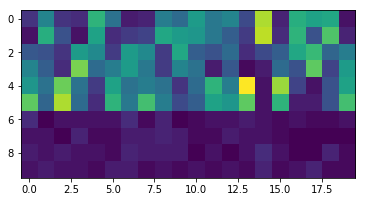

In [8]:
plt.imshow(data.todense());

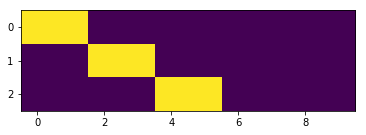

In [9]:
plt.imshow(sim.topics_by_index);

In [10]:
model = SimpleHierarchicalTopicModel(
    branching_factors = [2], num_epochs = 100,
    batch_size = 100, vocab = vocab,
    save_params_history = True)

In [11]:
model.fit(data)
top_words = model.get_top_words_by_node(num_words = 10)
model.print_top_words_by_node(num_words = 10);

100%|██████████| 2000/2000 [00:01<00:00, 1388.49it/s, Status=computing statistics]

Top words by node:
()  : w5, w4, w1, w0, w2, w3, w8, w6, w9, w7
(0,): w5, w4, w1, w0, w2, w3, w8, w6, w9, w7
(1,): w5, w4, w1, w0, w2, w3, w8, w6, w9, w7


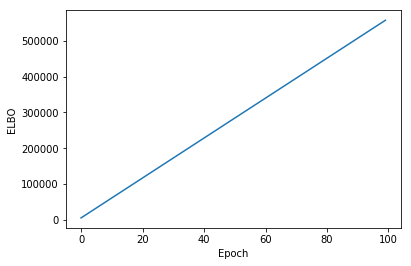

In [12]:
fig, ax = plt.subplots()
ax.plot(model.get_stats_by_epoch("epoch_index"), model.get_stats_by_epoch("ELBO"))
ax.set_xlabel("Epoch")
ax.set_ylabel("ELBO")
None

In [13]:
var_params = dict()
for name in ["DL", "DD", "DV", "L", "D"]:
    var_params[name] = model.get_stats_by_epoch("var_params_" + name)
epoch_indices = model.get_stats_by_epoch("epoch_index")

In [14]:
for k, v in var_params.items():
    print("{:2}: {}".format(k, v.shape))

D : (101, 2000, 2)
L : (101, 2000, 2)
DV: (101, 3, 10)
DD: (101, 20, 2)
DL: (101, 20, 2)


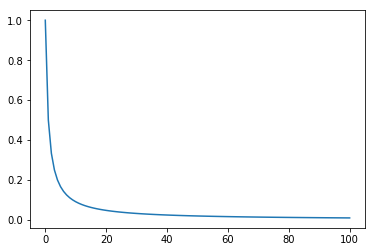

In [24]:
plt.plot(model.get_stats_by_epoch("step_size"));

In [30]:
def norm_variance_dirichlet(X, axis = -1):
    a0 = X.sum(axis = axis, keepdims = True)
    variance = X * (a0 - X) / (a0 ** 2 * (a0 + 1.0))
    norm_variance = np.linalg.norm(variance, axis = axis)
    return norm_variance

In [36]:
def mean_dirichlet(X, axis = -1):
    return X / X.sum(axis = axis, keepdims = True)

In [45]:
zzz1 = np.arange(20).reshape(4,5)
zzz2 = np.arange(5)
np.broadcast_arrays(zzz1, zzz2)

[array([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]]), array([[0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4]])]

In [83]:
def mean_discrete(p, axis = -1, keepdims = False):
    print(axis, len(p.shape))
    axis = axis if axis >= 0 else len(p.shape) + axis
    print(axis)
    values_target_shape = [1 if i != axis else p.shape[axis] for i in range(len(p.shape))]
    values = np.arange(p.shape[axis]).reshape(values_target_shape)
    print(p.shape, values.shape)
    values, p = np.broadcast_arrays(values, p)
    return np.sum(values * p, axis = axis, keepdims = keepdims)

In [121]:
def variance_discrete(p, axis = -1):
    axis = axis if axis >= 0 else len(p.shape) + axis
    values_target_shape = [1 if i != axis else p.shape[axis] for i in range(len(p.shape))]
    values = np.arange(p.shape[axis]).reshape(values_target_shape)
    print(values.shape, p.shape)
    print(values)
    values, p = np.broadcast_arrays(values, p)
    print(values)
    zzz = np.sum((values ** 2) * p, axis = axis)
    mean_sq = mean_discrete(p, axis = axis) ** 2
    print(values.shape, p.shape, zzz.shape, mean_sq.shape)
    return zzz - mean_sq

In [122]:
mean_discrete(var_params["L"][:, 0, :])

-1 2
1
(101, 2) (1, 2)


array([ 0.50215816,  0.49891169,  0.49853751,  0.49835957,  0.49823824,
        0.49814508,  0.49806899,  0.49800443,  0.49794823,  0.49789835,
        0.49785346,  0.49781259,  0.49777505,  0.4977403 ,  0.49770793,
        0.49767763,  0.49764912,  0.49762219,  0.49759668,  0.49757242,
        0.49754929,  0.49752719,  0.49750602,  0.4974857 ,  0.49746617,
        0.49744735,  0.4974292 ,  0.49741167,  0.49739471,  0.49737828,
        0.49736236,  0.4973469 ,  0.49733188,  0.49731728,  0.49730307,
        0.49728922,  0.49727572,  0.49726256,  0.49724971,  0.49723715,
        0.49722488,  0.49721288,  0.49720114,  0.49718964,  0.49717837,
        0.49716734,  0.49715652,  0.4971459 ,  0.49713548,  0.49712526,
        0.49711522,  0.49710535,  0.49709566,  0.49708612,  0.49707675,
        0.49706753,  0.49705845,  0.49704952,  0.49704073,  0.49703207,
        0.49702353,  0.49701513,  0.49700684,  0.49699867,  0.49699061,
        0.49698267,  0.49697483,  0.4969671 ,  0.49695946,  0.49

In [123]:
variance_discrete(var_params["L"][:, 0, :])

(1, 2) (101, 2)
[[0 1]]
[[0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]]
1 2
1
(101, 2) (1, 2)
(101, 2) (101, 2) (101,) (101,)


array([ 0.24999534,  0.24999882,  0.24999786,  0.24999731,  0.2499969 ,
        0.24999656,  0.24999627,  0.24999602,  0.24999579,  0.24999558,
        0.24999539,  0.24999522,  0.24999505,  0.24999489,  0.24999475,
        0.24999461,  0.24999447,  0.24999435,  0.24999422,  0.24999411,
        0.24999399,  0.24999389,  0.24999378,  0.24999368,  0.24999358,
        0.24999348,  0.24999339,  0.2499933 ,  0.24999321,  0.24999313,
        0.24999304,  0.24999296,  0.24999288,  0.2499928 ,  0.24999273,
        0.24999265,  0.24999258,  0.24999251,  0.24999244,  0.24999237,
        0.2499923 ,  0.24999223,  0.24999217,  0.2499921 ,  0.24999204,
        0.24999198,  0.24999191,  0.24999185,  0.24999179,  0.24999174,
        0.24999168,  0.24999162,  0.24999156,  0.24999151,  0.24999145,
        0.2499914 ,  0.24999135,  0.24999129,  0.24999124,  0.24999119,
        0.24999114,  0.24999109,  0.24999104,  0.24999099,  0.24999094,
        0.2499909 ,  0.24999085,  0.2499908 ,  0.24999076,  0.24

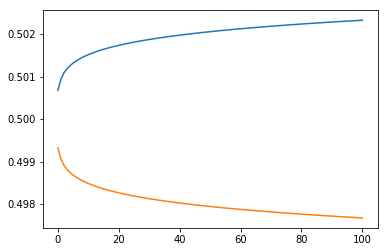

In [43]:
zzz = mean_dirichlet(var_params["DL"][:, 0, :])
plt.plot(zzz);

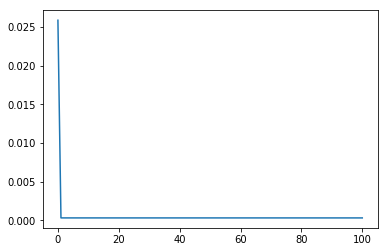

In [35]:
zzz = norm_variance_dirichlet(var_params["DV"][:, 0, :])
plt.plot(zzz);

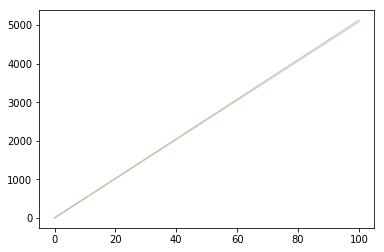

In [25]:
plt.plot(var_params["DL"][:, 0, :], alpha=0.3);

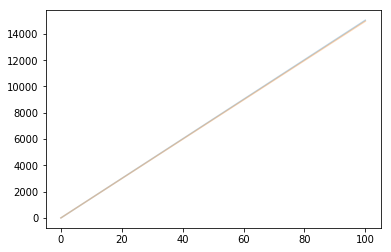

In [27]:
plt.plot(var_params["DD"][:, 0, :], alpha=0.3);

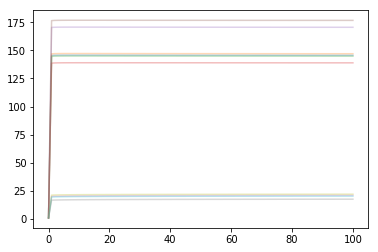

In [22]:
plt.plot(var_params["DV"][:, 0, :], alpha=0.3);

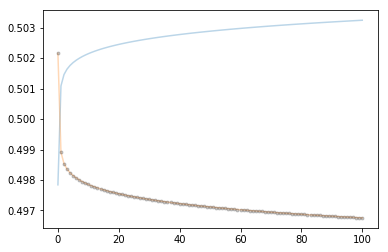

In [58]:
plt.plot(var_params["L"][:, 0, :], alpha=0.3);
plt.plot(mean_discrete(var_params["L"][:, 0, :]), 'k.', alpha=0.2);

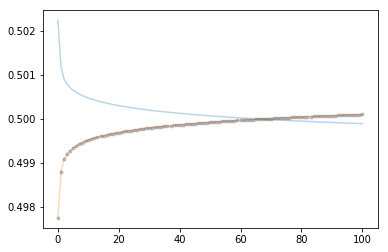

In [59]:
plt.plot(var_params["D"][:, 0, :], alpha=0.3);
plt.plot(mean_discrete(var_params["D"][:, 0, :]), 'k.', alpha=0.2);

In [17]:
topic_vectors = model.get_expected_topic_vectors()

In [18]:
topic_vectors.shape

(3, 10)

In [19]:
variance = topic_vectors.var(axis=0)
print(variance.shape)
np.linalg.norm(variance)

(10,)


2.1561490128993105e-06

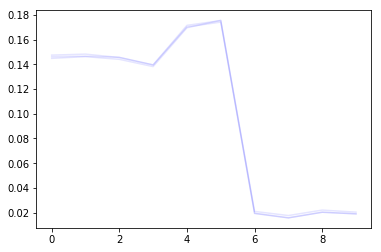

In [20]:
for i in range(3):
    plt.plot(topic_vectors[i,:], color='b', alpha=0.1);

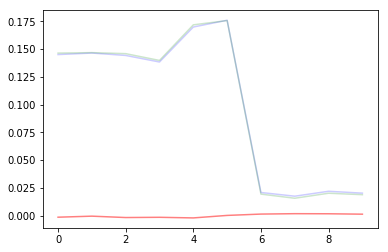

In [21]:
plt.plot(topic_vectors[0,:], color='b', alpha=0.2)
plt.plot(topic_vectors[1,:], color='g', alpha=0.2)
plt.plot(topic_vectors[0,:] - topic_vectors[1,:], color='r', alpha=0.5)
None